In [26]:
from cs.src.computervision import MODEL_CFG_DIR, MODEL_WEIGTS_DIR_DRACO, CLASSES, ObjectDetection
import cv2
import re
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

net = ObjectDetection(MODEL_WEIGTS_DIR_DRACO)

def test_image(filedir: str) -> tuple[float, float | None, float | None]:
    img = cv2.imread(filedir)

    leaders = net.process(img)

    if len(leaders) > 0:
        return leaders[0].confidence, leaders[0].center_x_non_dimensional, leaders[0].center_y_non_dimensional

    return 0, None, None

def regexdatetime(input_comment: str) -> datetime:
    result = re.search(r"t(-?[0-9]+.[0-9]+)c?(-?[0-9]+)?", input_comment)
    if result.group(2) is not None:
        return datetime.fromtimestamp(float(result.group(2))/1e6)
    return datetime.fromtimestamp(float(result.group(1)))

In [27]:
images_dir = "C:\\Users\\alvar\\University of Southampton\\GDP - General\\Flight Day 2\\images"

from os import listdir
from os.path import isfile, join
images = [join(images_dir, f) for f in listdir(images_dir) if isfile(join(images_dir, f))]

images.pop(0)

data = pd.DataFrame({"filedir": images})

with open("success_max_res.txt", "r") as f:
    in_pic = [i for i in f.read().split("\n")]
    data["contains_acft"] = data["filedir"].isin(in_pic)


with open("success.txt", "r") as f:
    detected = [i for i in f.read().split("\n")]
    data["detected"] = data["filedir"].isin(detected)

with open("incorrect.txt", "r") as f:
    incorrect = [i for i in f.read().split("\n")]
    data["Incorrect detection"] = data["filedir"].isin(incorrect)

data["datetime"] = data["filedir"].map(regexdatetime)
data = data[(data["datetime"] > datetime(2023, 5, 2, 13, 0, 0)) & (data["datetime"] < datetime(2023, 5, 2, 14, 0, 0))]
data = data.reset_index()

confidences = np.zeros(len(data))
x = np.zeros(len(data))
y = np.zeros(len(data))

for inx, i in data.iterrows():
    if i["detected"] or i["Incorrect detection"]:
        confidences[inx], x[inx], y[inx] = test_image(i["filedir"])

    else:
        confidences[inx] = 0

data["confidence"] = confidences
data["x"] = x
data["y"] = y


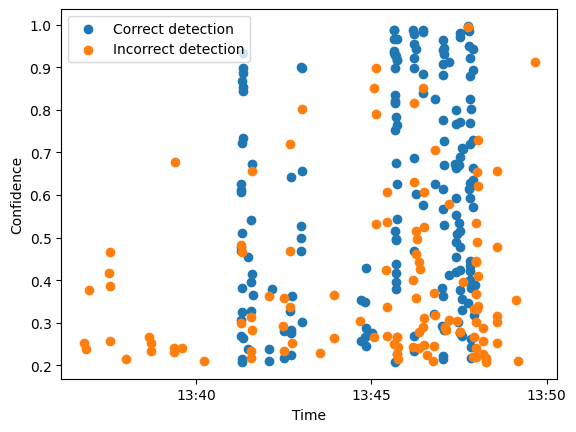

In [33]:
import matplotlib.dates as mdates

correct = data[data["detected"]].reset_index()
fig, ax = plt.subplots()

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.scatter(correct["datetime"], correct["confidence"], label="Correct detection")
incorrect = data[data["Incorrect detection"]]
ax.scatter(incorrect["datetime"], incorrect["confidence"], label="Incorrect detection")
ax.set_xlabel("Time")
ax.set_ylabel("Confidence")
ax.legend()

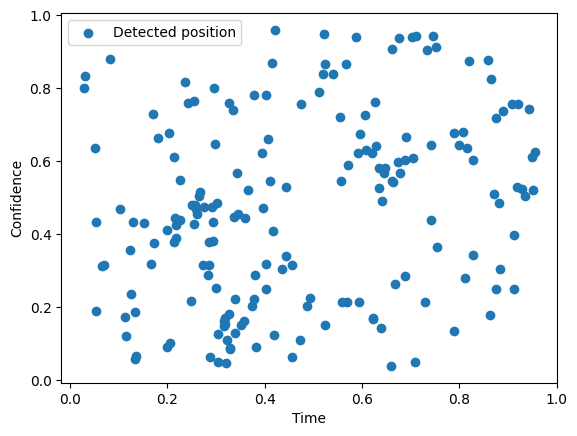

In [34]:
fig, ax = plt.subplots()

ax.scatter(correct["x"], correct["y"], label="Detected position")
ax.set_xlabel("Time")
ax.set_ylabel("Confidence")
ax.legend()

In [35]:
correct["dx"] = [correct["x"][inx] - correct["x"][inx + 1] for inx, i in correct.iterrows() if inx + 1 < len(correct)] + [0]
correct["dy"] = [correct["y"][inx] - correct["y"][inx + 1] for inx, i in correct.iterrows() if inx + 1 < len(correct)] + [0]

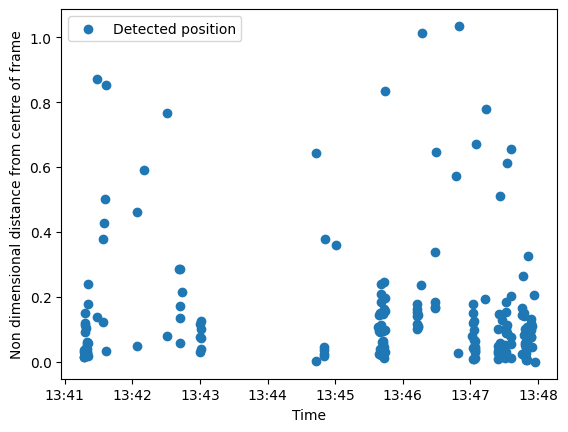

In [36]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax.scatter(correct["datetime"], np.sqrt(correct["dx"]**2 + correct["dy"]**2), label="Detected position")
ax.set_xlabel("Time")
ax.set_ylabel("Non dimensional distance from centre of frame")
ax.legend()

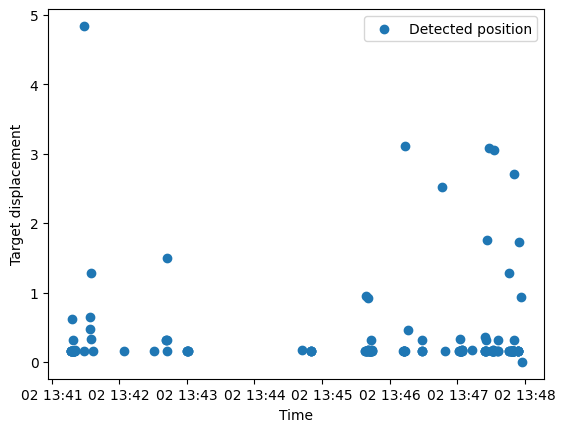

In [37]:
correct["dt"] = [(correct["datetime"][inx + 1] - correct["datetime"][inx]).total_seconds() for inx, i in correct.iterrows() if inx + 1 < len(correct)] + [0]

stable = correct[correct["dt"] < 5]

plt.scatter(stable["datetime"], stable["dt"], label="Detected position")
plt.xlabel("Time")
plt.ylabel("Target displacement")
plt.legend()
plt.show()

In [84]:
max_dt = 1
mint = 2
start = correct['datetime'][0]
start_inx = 0

for inx, i in correct.iterrows():
    if i["dt"] > max_dt:
        if (i['datetime'] - start).total_seconds() > mint:
            print(f"From {start} to {i['datetime']} with lentgh {(i['datetime'] - start).total_seconds()} with maximum dt between frames of {correct['dt'][start_inx:inx].max()}")

        start = correct['datetime'][inx + 1]
        start_inx = inx + 1

From 2023-05-02 13:45:41.882972 to 2023-05-02 13:45:44.424403 with lentgh 2.541431 with maximum dt between frames of 0.313164
From 2023-05-02 13:47:01.714664 to 2023-05-02 13:47:04.586602 with lentgh 2.871938 with maximum dt between frames of 0.324076
From 2023-05-02 13:47:47.525596 to 2023-05-02 13:47:50.674190 with lentgh 3.148594 with maximum dt between frames of 0.321841
